# Business Understanding
Die automatische Vorhersage demografischer Merkmale anhand von Gesichtsaufnahmen gewinnt zunehmend an Bedeutung in verschiedenen Anwendungsfeldern. Im Marketing und Einzelhandel ermöglicht sie eine zielgerichtete Kundenansprache durch personalisierte Inhalte, etwa in Form von Werbung oder Produktempfehlungen. In sicherheitskritischen Bereichen unterstützt die Analyse bei Zugangskontrollen oder demografischem Screening, während in der sozialwissenschaftlichen Forschung große Bilddatensätze effizient zur Untersuchung gesellschaftlicher Entwicklungen ausgewertet werden können. Dieses Projekt zielt auf die Entwicklung eines neuronalen Netzwerks zur automatisierten Klassifikation der ethnischen Zugehörigkeit auf Basis von Gesichtsbildern. Zur Bewertung der Modellleistung wird die Accuracy als Zielmetrik verwendet, da sie bei mehrklassigen Klassifikationsproblemen mit annähernd gleichverteilten Klassenanteilen eine gut interpretierbare Aussage darüber liefert, wie häufig das Modell insgesamt richtige Vorhersagen trifft.


# Data Understanding

In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.layers as L
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import train_test_split
import keras_tuner as kt
from tensorflow.keras import layers, models, regularizers, Input

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nipunarora8/age-gender-and-ethnicity-face-data-csv")

print("Path to dataset files:", path)

100%|██████████| 63.2M/63.2M [00:00<00:00, 78.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nipunarora8/age-gender-and-ethnicity-face-data-csv/versions/1


In [4]:
csv_file = os.path.join(path, "age_gender.csv")
data = pd.read_csv(csv_file)
data = data.drop("img_name", axis = 1)

## Converting pixels into numpy array
data['pixels']=data['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))


In [5]:
# First look an data
print('Total rows: {}'.format(len(data)))
data.isnull().sum()
data.head()

Total rows: 23705


,age,ethnicity,gender,pixels
0,1,2,0,"[129.0, 128.0, 128.0, 126.0, 127.0, 130.0, 133..."
1,1,2,0,"[164.0, 74.0, 111.0, 168.0, 169.0, 171.0, 175...."
2,1,2,0,"[67.0, 70.0, 71.0, 70.0, 69.0, 67.0, 70.0, 79...."
3,1,2,0,"[193.0, 197.0, 198.0, 200.0, 199.0, 200.0, 202..."
4,1,2,0,"[202.0, 205.0, 209.0, 210.0, 209.0, 209.0, 210..."


## Distributions

In [6]:
## calculating distributions
age_dist = data['age'].value_counts()
ethnicity_dist = data['ethnicity'].value_counts()
gender_dist = data['gender'].value_counts().rename(index={0:'Male',1:'Female'})

def distribution_plot(x, y, name):
    fig = go.Figure([
        go.Bar(x=x, y=y)
    ])
    #fig.update_layout(title_text=name)
    fig.show()


In [7]:
distribution_plot(age_dist.index,age_dist.values,'Age Distribution')

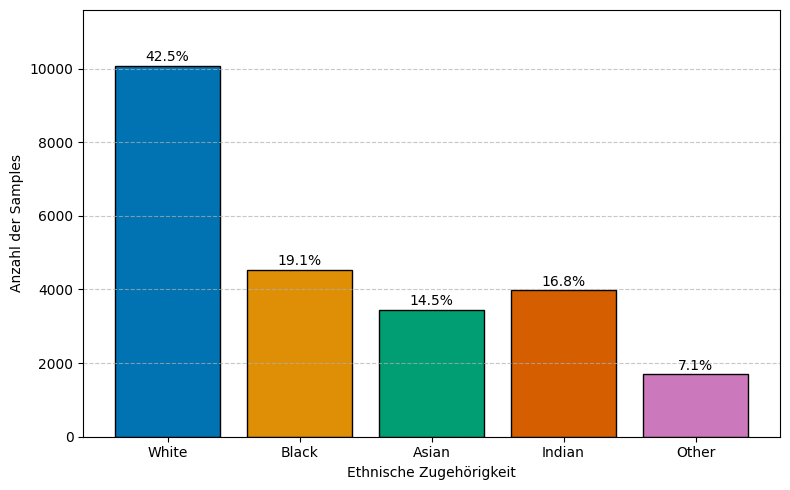

In [8]:
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

# Mapping von Klasse zu Label
ethnicity_map = {
    0: "White",
    1: "Black",
    2: "Asian",
    3: "Indian",
    4: "Other"
}

# Sortierte Häufigkeiten
ethnicity_dist = data['ethnicity'].value_counts().sort_index()
labels = [ethnicity_map[i] for i in ethnicity_dist.index]
counts = ethnicity_dist.values
percentages = counts / counts.sum() * 100

# Farben aus Colorbrewer Palette (Seaborn-kompatibel)
colors = sns.color_palette("colorblind", len(labels))  # alternativ: "Set2", "Paired"

# Balkendiagramm
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, counts, color=colors, edgecolor='black')

# Prozentwerte über den Balken anzeigen
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 50, f"{pct:.1f}%",
             ha='center', va='bottom', fontsize=10)

# Achsen & Titel
plt.ylabel('Anzahl der Samples')
plt.xlabel('Ethnische Zugehörigkeit')
plt.ylim(0, max(counts) * 1.15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Speichern
plt.tight_layout()
plt.savefig("ethnicity_distribution_colorblind.png", dpi=300)
plt.show()

In [9]:
distribution_plot(gender_dist.index,gender_dist.values,'Gender Distribution')

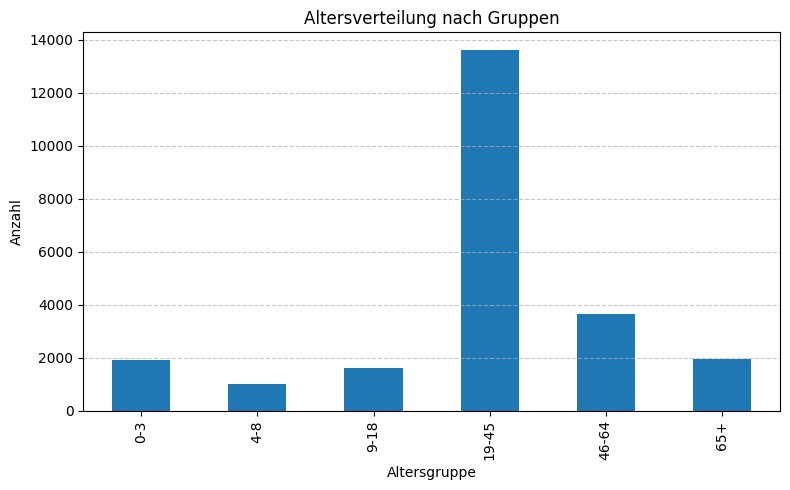

In [10]:
# Altersgruppen definieren (Bins)
bins = [0, 3, 8, 18, 45, 64, 116]
labels = ['0-3', '4-8', '9-18', '19-45', '46-64', '65+']

# Altersgruppen als neue Spalte hinzufügen
data['age_group'] = pd.cut(data['age'], bins=bins, labels=labels, right=True)

# Häufigkeiten je Altersgruppe berechnen
age_group_counts = data['age_group'].value_counts().sort_index()

# Balkendiagramm erstellen
plt.figure(figsize=(8, 5))
age_group_counts.plot(kind='bar')
plt.title('Altersverteilung nach Gruppen')
plt.xlabel('Altersgruppe')
plt.ylabel('Anzahl')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Shape of Images

In [11]:
first_image_array = data['pixels'].iloc[0]
image_size = int(np.sqrt(len(first_image_array)))
print(f"Das Bild hat die Maße: {image_size}x{image_size}")

pixel_lengths = data['pixels'].apply(len)
unique_lengths = pixel_lengths.unique()

print("Verschiedene Bildgrößen (Anzahl Pixel):", unique_lengths)

Das Bild hat die Maße: 48x48
Verschiedene Bildgrößen (Anzahl Pixel): [2304]


## Normalize and Reshape Data

In [12]:
## normalizing pixels data
data['pixels'] = data['pixels'].apply(lambda x: x/255)

In [13]:
# Alle Bilder in 48x48 umformen (für Graustufenbilder ohne Kanal-Dimension)
images = np.stack(data['pixels'].apply(lambda x: x.reshape(48, 48)))
print("Bilderform:", images.shape)

# Optional (falls du Kanal-Dimension brauchst, z. B. für CNN-Eingabe):
images = images.reshape(-1, 48, 48, 1)
print("Bilderform nach Kanal-Dimension:", images.shape)

Bilderform: (23705, 48, 48)
Bilderform nach Kanal-Dimension: (23705, 48, 48, 1)


## Image Overview

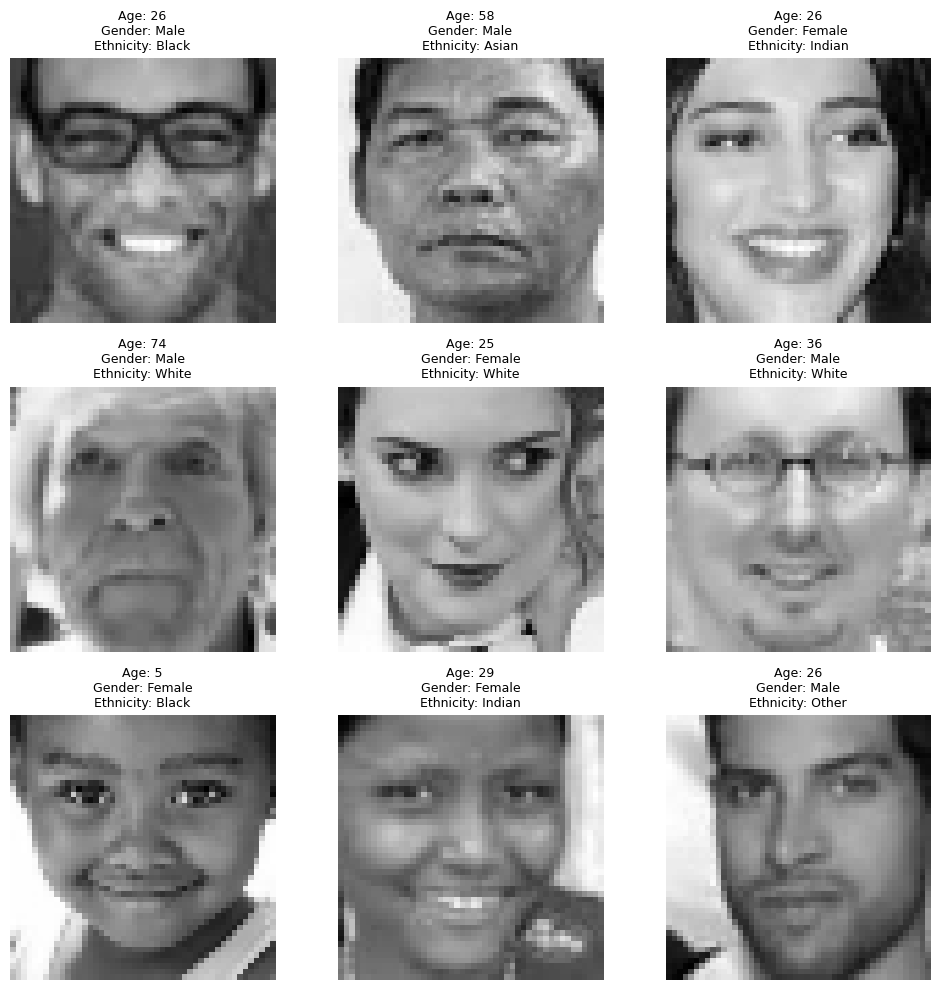

In [14]:
# Zufällig 9 Bilder auswählen
random_indices = np.random.choice(len(data), size=9, replace=False)
selected_images = images[random_indices]
selected_rows = data.iloc[random_indices]

# Mapping für Gender und Ethnicity (optional anpassbar)
gender_map = {0: "Male", 1: "Female"}
ethnicity_map = {
    0: "White",
    1: "Black",
    2: "Asian",
    3: "Indian",
    4: "Other"
}

# Galerie anzeigen
plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(selected_images[i], cmap='gray')

    age = selected_rows.iloc[i]['age']
    gender = gender_map.get(selected_rows.iloc[i]['gender'], "Unknown")
    ethnicity = ethnicity_map.get(selected_rows.iloc[i]['ethnicity'], "Unknown")

    plt.title(f"Age: {age}\nGender: {gender}\nEthnicity: {ethnicity}", fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.savefig("sample_gallery.png", dpi=300)
plt.show()

# Data Preperation

In [15]:
# Features (X): die Bilder
X = images

# Targets (Y): die 3 Spalten
y_age = data['age'].astype(int)
y_gender = data['gender'].astype(int)
y_ethnicity = data['ethnicity'].astype(int)


In [16]:
from sklearn.preprocessing import LabelEncoder

# Alter als Klasse (z. B. Klasse 0 bis max age)
max_age = data['age'].max()
age_labels = data['age'].astype(int)

# Gender und Ethnicity bleiben wie sie sind (0/1 bzw. 0–4)
gender_labels = data['gender'].astype(int)
ethnicity_labels = data['ethnicity'].astype(int)

## Test-Train-Split

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_ethnicity, test_size=0.3, random_state=42)

In [18]:
# Korrektur der Unbalanciertheit für das Training durch Gewichtungen

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# y_train = Integer-Klassen (z. B. 0–4)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# In dict umwandeln
class_weight_dict = dict(enumerate(class_weights))


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator mit Augmentierungen
datagen = ImageDataGenerator(
    rotation_range=5,          # max. ±5° Drehung
    zoom_range=0.1,            # bis zu ±10% Zoom
    width_shift_range=0.1,     # bis zu ±10% horizontale Verschiebung
    height_shift_range=0.1,    # bis zu ±10% vertikale Verschiebung
    shear_range=0.05,          # leichte Scherung (optional)
    horizontal_flip=True,      # Spiegelung aktivieren
    fill_mode='nearest'        # leere Pixel füllen
)

#train_generator = datagen.flow(X_train, y_train, batch_size=64)

# Modeling

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input

def define_model(activation='relu', loss='sparse_categorical_crossentropy', num_classes=5):
    input_layer = Input(shape=(48, 48, 1))

    # Block 1
    x = layers.Conv2D(32, (3, 3), activation=activation, padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 2
    x = layers.Conv2D(64, (3, 3), activation=activation, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 3
    x = layers.Conv2D(128, (3, 3), activation=activation, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Dense Block
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation=activation)(x)
    x = layers.Dropout(0.5)(x)

    # Output Layer
    output = layers.Dense(num_classes, activation='softmax')(x)

    # Modell definieren
    model = models.Model(inputs=input_layer, outputs=output)

    # Modell kompilieren
    model.compile(
        optimizer='adam',
        loss=loss,
        metrics=['accuracy']
    )

    return model


In [ ]:
model = define_model()

In [ ]:
"""model.compile(
    optimizer='adam',
    loss={
        'age': 'sparse_categorical_crossentropy',
        'gender': 'binary_crossentropy',
        'ethnicity': 'sparse_categorical_crossentropy'
    },
    metrics={
        'age': ['accuracy', tf.keras.metrics.MeanAbsoluteError()],
        'gender': ['accuracy'],
        'ethnicity': ['accuracy']
    }
)
"""

"model.compile(\n    optimizer='adam',\n    loss={\n        'age': 'sparse_categorical_crossentropy',\n        'gender': 'binary_crossentropy',\n        'ethnicity': 'sparse_categorical_crossentropy'\n    },\n    metrics={\n        'age': ['accuracy', tf.keras.metrics.MeanAbsoluteError()],\n        'gender': ['accuracy'],\n        'ethnicity': ['accuracy']\n    }\n)\n"

In [ ]:
import tensorflow as tf

class EarlyStoppingByAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, threshold=0.70):
        super().__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy')
        if val_acc is not None and val_acc >= self.threshold:
            print(f"\nValidation accuracy reached {val_acc:.2%} (threshold: {self.threshold:.2%}). Stopping training.")
            self.model.stop_training = True

early_stop_test = EarlyStoppingByAccuracy(threshold=0.80)

In [19]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,              # Stoppt nach 3 Epochen ohne Verbesserung
    restore_best_weights=True
)


In [20]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,              # Lernrate wird halbiert
    patience=2,              # nach 2 Epochen ohne Verbesserung
    min_lr=1e-5              # unter diese Grenze geht sie nicht
)


In [ ]:
from contextlib import redirect_stdout

# Modell-Architektur als Textdatei speichern
with open("model_summary.txt", "w") as f:
    with redirect_stdout(f):
        model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,274,757 (4.86 MB)

 Trainable params: 1,274,309 (4.86 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=[early_stop_test, lr_scheduler]
)

"""
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 64,
    validation_data=(X_test, y_test),
    epochs=10,
    class_weight=class_weight_dict,
    callbacks=[early_stop_test, lr_scheduler]
)"""

Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 151s 566ms/step - accuracy: 0.3384 - loss: 2.1237 - val_accuracy: 0.4321 - val_loss: 1.8721 - learning_rate: 0.0010
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 199s 554ms/step - accuracy: 0.5403 - loss: 1.1989 - val_accuracy: 0.6375 - val_loss: 1.0301 - learning_rate: 0.0010
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 195s 529ms/step - accuracy: 0.6118 - loss: 1.0493 - val_accuracy: 0.6776 - val_loss: 0.8805 - learning_rate: 0.0010
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 128s 475ms/step - accuracy: 0.6590 - loss: 0.9501 - val_accuracy: 0.5754 - val_loss: 1.0797 - learning_rate: 0.0010
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 141s 472ms/step - accuracy: 0.6753 - loss: 0.8966 - val_accuracy: 0.5973 - val_loss: 0.9458 - learning_rate: 0.0010
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 151s 509ms/step - accuracy: 0.6859 - loss: 0.8076 - val_accuracy: 0.7451 - val_loss: 0.6975 - learning_rate: 5.0000e-04
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 143s 512ms/step - ac

'\nhistory = model.fit(\n    train_generator,\n    steps_per_epoch=len(X_train) // 64,\n    validation_data=(X_test, y_test),\n    epochs=10,\n    class_weight=class_weight_dict,\n    callbacks=[early_stop_test, lr_scheduler]\n)'

Epochs: 10 -->
accuracy: 0.7741 - loss: 0.5720 - val_accuracy: 0.7476 - val_loss: 0.7107 - learning_rate: 0.0010 zu 0.0005

Epochs: 15 -->
accuracy: 0.8442 - loss: 0.3827 - val_accuracy: 0.7688 - val_loss: 0.7446 - learning_rate: 0.0010 zu 0.0005

## Hyperparameter-Tuning

In [ ]:
import keras_tuner as kt
from tensorflow.keras import layers, models, regularizers, Input

def build_model(hp):
    input_layer = Input(shape=(48, 48, 1))

    # Hyperparameter: L2-Regularisierung
    l2_value = hp.Choice('l2_reg', values=[1e-3, 1e-2])

    # Block 1
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(l2_value))(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 2
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(l2_value))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 3
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(l2_value))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)

    # Hyperparameter: Dense-Units
    x = layers.Dense(hp.Int('dense_units', min_value=128, max_value=512, step=128),
                     activation='relu',
                     kernel_regularizer=regularizers.l2(l2_value))(x)

    # Hyperparameter: Dropout-Rate
    x = layers.Dropout(hp.Float('dropout', min_value=0.4, max_value=0.6, step=0.1))(x)

    output = layers.Dense(5, activation='softmax')(x)

    model = models.Model(inputs=input_layer, outputs=output)

    # Hyperparameter: Lernrate
    lr = hp.Choice('learning_rate', values=[1e-2, 1e-3])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [ ]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='tuning_logs',
    project_name='ethnicity_cnn'
)


In [ ]:
tuner.search(X_train, y_train,
             validation_data=(X_test, y_test),
             epochs=10,
             batch_size=64,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])


Trial 30 Complete [00h 18m 51s]
val_accuracy: 0.4334926903247833

Best val_accuracy So Far: 0.7789651155471802
Total elapsed time: 04h 51m 53s


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparams = tuner.get_best_hyperparameters(1)[0]

print("Beste Hyperparameter:")
print(best_hyperparams.values)


Beste Hyperparameter:
{'l2_reg': 0.001, 'dense_units': 128, 'dropout': 0.4, 'learning_rate': 0.001, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0012'}


Beste Hyperparameter:
{'l2_reg': 0.001, 'dense_units': 128, 'dropout': 0.4, 'learning_rate': 0.001, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0012'}

# Modeling with best Hyperparameters

In [21]:
# Beste Hyperparameter explizit definieren
best_hyperparams_values = {
    'l2_reg': 0.001,
    'dense_units': 128,
    'dropout': 0.4,
    'learning_rate': 0.001
}

# Funktion zur Modell-Erstellung direkt mit festen Werten (ohne hp-Objekt)
def build_model_from_values(hparams):
    input_layer = Input(shape=(48, 48, 1))

    l2_value = hparams['l2_reg']

    # Block 1
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(l2_value))(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 2
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(l2_value))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 3
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(l2_value))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)

    x = layers.Dense(hparams['dense_units'], activation='relu',
                     kernel_regularizer=regularizers.l2(l2_value))(x)
    x = layers.Dropout(hparams['dropout'])(x)

    output = layers.Dense(5, activation='softmax')(x)

    model = models.Model(inputs=input_layer, outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hparams['learning_rate']),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [22]:
# Modell bauen
model = build_model_from_values(best_hyperparams_values)

In [ ]:
# Modell trainieren mit History-Tracking
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]
)


# Evaluation

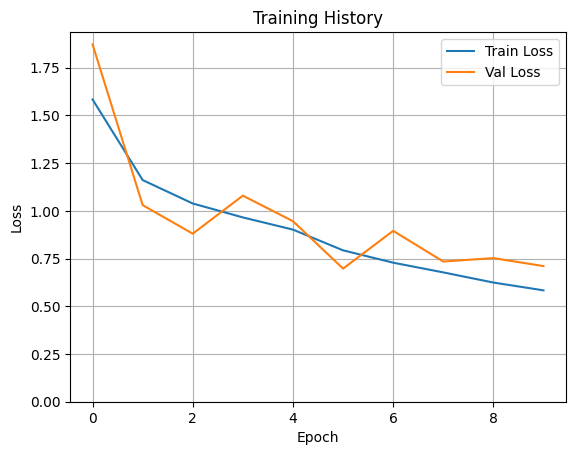

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.ylim(bottom=0.0)  # y-Achse beginnt bei 0.0
plt.legend()
plt.grid(True)
plt.savefig("training_history.png")
plt.show()


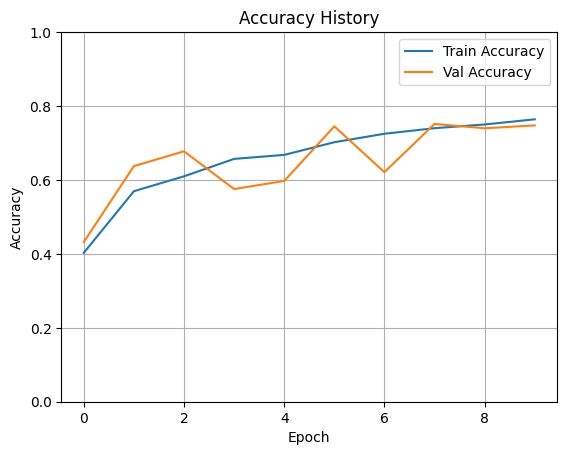

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy History')
plt.ylim(0.0, 1.0)  # y-Achse fix auf [0, 1]
plt.legend()
plt.grid(True)
plt.savefig("accuracy_history.png")
plt.show()


223/223 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step


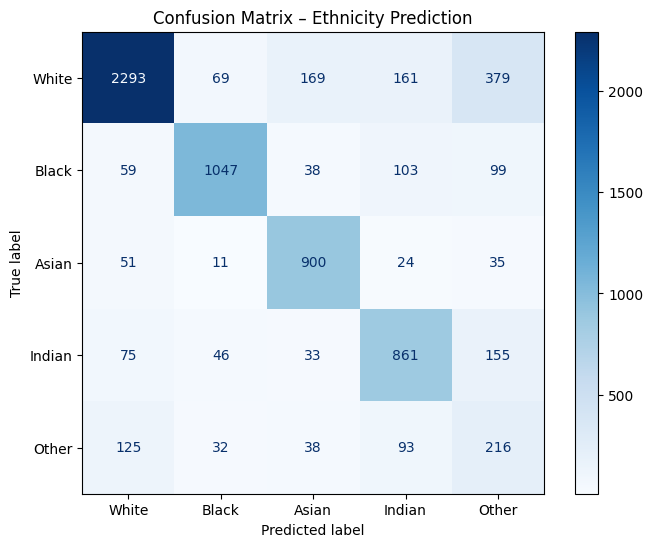

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Vorhersagen des Modells (z. B. auf X_test)
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# Confusion Matrix berechnen
cm = confusion_matrix(y_test, y_pred)

# Optional: Mapping für Labels
ethnicity_labels = ["White", "Black", "Asian", "Indian", "Other"]

# Confusion Matrix anzeigen
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ethnicity_labels)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Confusion Matrix – Ethnicity Prediction")
plt.savefig("confusion_matrix_ethnicity.png", dpi=300)
plt.show()


## Dummy Classifier

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Flatten für sklearn-kompatibles Format
X_train_flat = X_train.reshape(len(X_train), -1)
X_test_flat = X_test.reshape(len(X_test), -1)

strategies = ['most_frequent', 'stratified', 'uniform']

for strategy in strategies:
    print(f"\nDummy Classifier – Strategy: {strategy}")
    dummy = DummyClassifier(strategy=strategy, random_state=42)
    dummy.fit(X_train_flat, y_train)
    y_pred = dummy.predict(X_test_flat)

    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.2%}")
    print(classification_report(y_test, y_pred))



Dummy Classifier – Strategy: most_frequent
Accuracy: 43.18%
              precision    recall  f1-score   support

           0       0.43      1.00      0.60      3071
           1       0.00      0.00      0.00      1346
           2       0.00      0.00      0.00      1021
           3       0.00      0.00      0.00      1170
           4       0.00      0.00      0.00       504

    accuracy                           0.43      7112
   macro avg       0.09      0.20      0.12      7112
weighted avg       0.19      0.43      0.26      7112


Dummy Classifier – Strategy: stratified
Accuracy: 27.59%
              precision    recall  f1-score   support

           0       0.44      0.42      0.43      3071
           1       0.19      0.19      0.19      1346
           2       0.16      0.16      0.16      1021
           3       0.16      0.18      0.17      1170
           4       0.08      0.08      0.08       504

    accuracy                           0.28      7112
   macro avg

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



# Demonstration

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


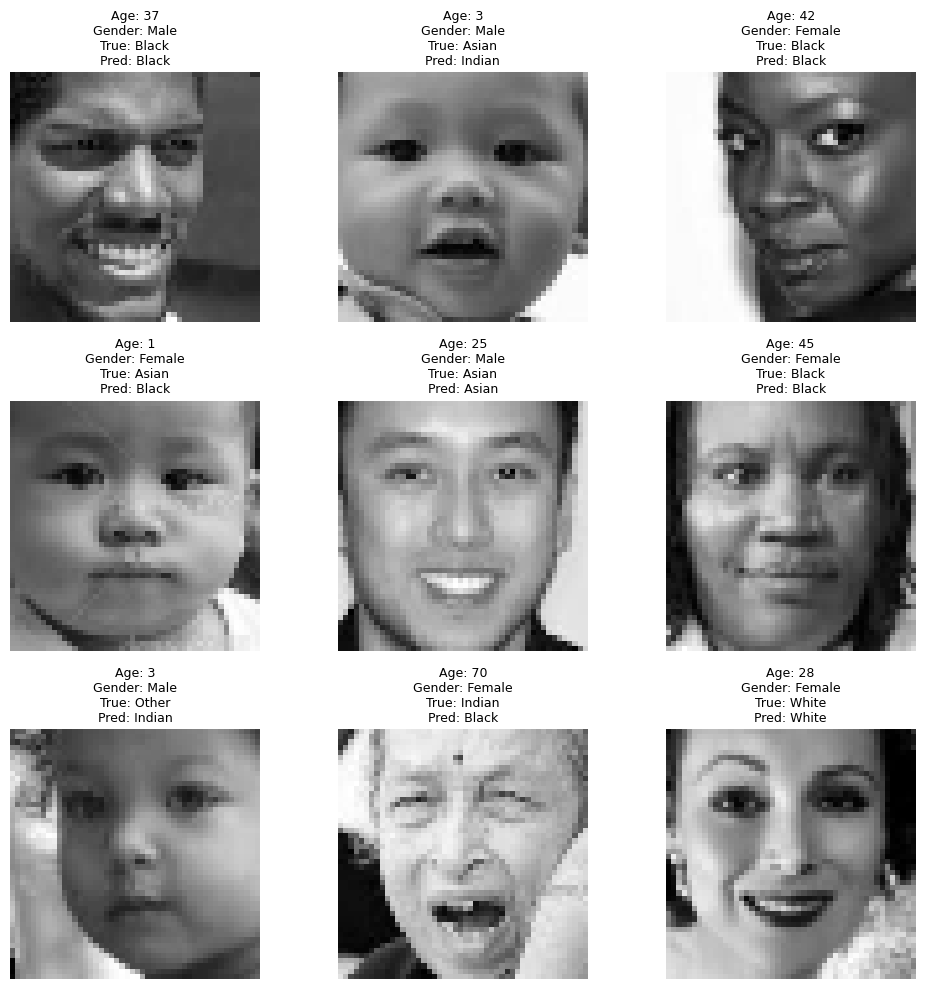

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 9 zufällige Indizes auswählen
random_indices = np.random.choice(len(data), size=9, replace=False)
selected_images = images[random_indices]
selected_rows = data.iloc[random_indices]

# Vorhersagen für diese Bilder
predictions = model.predict(selected_images)
predicted_classes = np.argmax(predictions, axis=1)

# Mapping für Ethnicity (ggf. anpassen)
ethnicity_map = {
    0: "White",
    1: "Black",
    2: "Asian",
    3: "Indian",
    4: "Other"
}
gender_map = {0: "Male", 1: "Female"}

# Galerie anzeigen
plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    # ggf. squeeze, wenn Bilder Form (48, 48, 1) haben
    plt.imshow(selected_images[i].squeeze(), cmap='gray')
    plt.axis('off')

    true_ethnicity = ethnicity_map.get(selected_rows.iloc[i]['ethnicity'], "Unknown")
    pred_ethnicity = ethnicity_map.get(predicted_classes[i], "Unknown")
    age = selected_rows.iloc[i]['age']
    gender = gender_map.get(selected_rows.iloc[i]['gender'], "Unknown")

    plt.title(f"Age: {age}\nGender: {gender}\nTrue: {true_ethnicity}\nPred: {pred_ethnicity}", fontsize=9)

plt.tight_layout()
plt.savefig("prediction_gallery.png", dpi=300)  # Speichert das Bild in hoher Auflösung
plt.show()



# Anhang

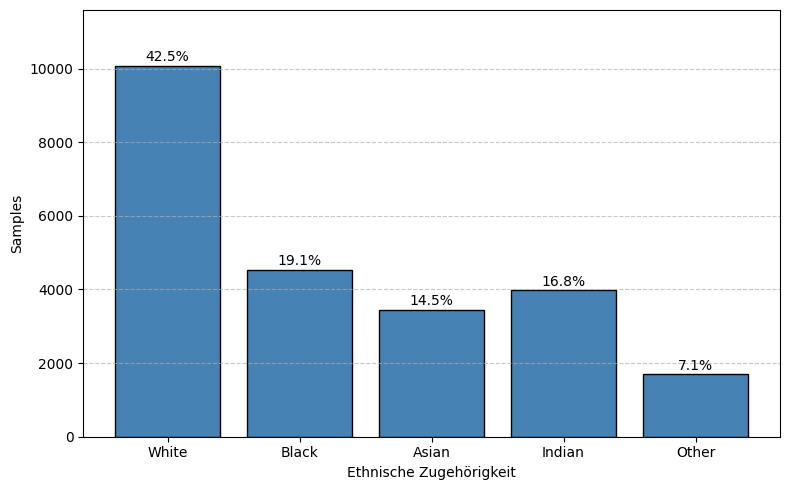

In [ ]:
import matplotlib.pyplot as plt

# Mapping von Klasse zu Label (falls noch nicht vorhanden)
ethnicity_map = {
    0: "White",
    1: "Black",
    2: "Asian",
    3: "Indian",
    4: "Other"
}

# Sortiere nach Klassenindex
ethnicity_dist = data['ethnicity'].value_counts().sort_index()
labels = [ethnicity_map[i] for i in ethnicity_dist.index]
counts = ethnicity_dist.values
percentages = counts / counts.sum() * 100

# Erstelle Balkendiagramm
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, counts, color='steelblue', edgecolor='black')

# Prozentwerte über den Balken anzeigen
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 50, f"{pct:.1f}%",
             ha='center', va='bottom', fontsize=10)

# Achsen & Titel
plt.ylabel('Samples')
plt.xlabel('Ethnische Zugehörigkeit')
plt.ylim(0, max(counts) * 1.15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot speichern
plt.tight_layout()
plt.savefig("ethnicity_distribution.png", dpi=300)
plt.show()


In [ ]:
model.save("ethnicity_model.h5")


In [ ]:
model.save('my_model.keras')

In [ ]:
import pandas as pd

# history ist das Rückgabeobjekt von model.fit(...)
df_history = pd.DataFrame(history.history)
df_history.to_csv("training_history.csv", index=False)



In [ ]:
from tensorflow.keras.models import load_model

# Lade dein gespeichertes Modell
model = load_model("ethnicity_model.h5")


In [ ]:
# Vorhersage auf Testdaten
y_pred_probs = model.predict(X_test)              # Wahrscheinlichkeiten (Softmax-Ausgabe)
y_pred = y_pred_probs.argmax(axis=1)              # Klassen-IDs (0–4)

# Beispiel: Vergleich mit Ground Truth
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


223/223 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step
              precision    recall  f1-score   support

           0       0.87      0.78      0.82      3071
           1       0.88      0.79      0.83      1346
           2       0.81      0.87      0.84      1021
           3       0.66      0.79      0.72      1170
           4       0.30      0.38      0.34       504

    accuracy                           0.77      7112
   macro avg       0.70      0.72      0.71      7112
weighted avg       0.79      0.77      0.78      7112



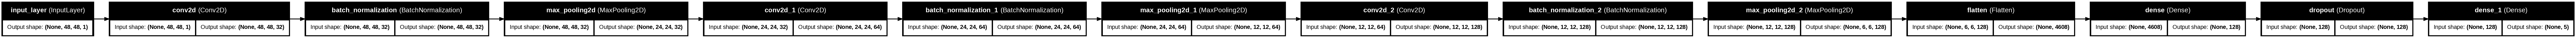

In [24]:
from tensorflow.keras.utils import plot_model

# Visualisierung der Architektur
plot_model(model, to_file='cnn_architecture.png', show_shapes=True, show_layer_names=True, dpi=96)


In [ ]:
while True:
    pass


<ipython-input-25-f2d8c08cc422>:240: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.



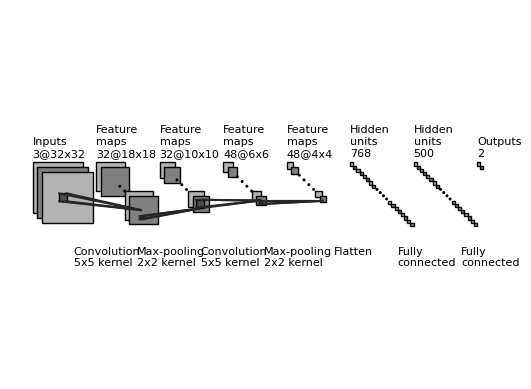

In [25]:
"""
Copyright (c) 2017, Gavin Weiguang Ding
All rights reserved.

Redistribution and use in source and binary forms, with or without
    modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this
    list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice,
    this list of conditions and the following disclaimer in the documentation
    and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its contributors
    may be used to endorse or promote products derived from this software
    without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
    AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
    IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE
    ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE
    LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR
    CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF
    SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS
    INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN
    CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE)
    ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE
    POSSIBILITY OF SUCH DAMAGE.
"""


import os
import numpy as np
import matplotlib.pyplot as plt
plt.rcdefaults()
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle

NumDots = 4
NumConvMax = 8
NumFcMax = 20
White = 1.
Light = 0.7
Medium = 0.5
Dark = 0.3
Darker = 0.15
Black = 0.


def add_layer(patches, colors, size=(24, 24), num=5,
              top_left=[0, 0],
              loc_diff=[3, -3],
              ):
    # add a rectangle
    top_left = np.array(top_left)
    loc_diff = np.array(loc_diff)
    loc_start = top_left - np.array([0, size[0]])
    for ind in range(num):
        patches.append(Rectangle(loc_start + ind * loc_diff, size[1], size[0]))
        if ind % 2:
            colors.append(Medium)
        else:
            colors.append(Light)


def add_layer_with_omission(patches, colors, size=(24, 24),
                            num=5, num_max=8,
                            num_dots=4,
                            top_left=[0, 0],
                            loc_diff=[3, -3],
                            ):
    # add a rectangle
    top_left = np.array(top_left)
    loc_diff = np.array(loc_diff)
    loc_start = top_left - np.array([0, size[0]])
    this_num = min(num, num_max)
    start_omit = (this_num - num_dots) // 2
    end_omit = this_num - start_omit
    start_omit -= 1
    for ind in range(this_num):
        if (num > num_max) and (start_omit < ind < end_omit):
            omit = True
        else:
            omit = False

        if omit:
            patches.append(
                Circle(loc_start + ind * loc_diff + np.array(size) / 2, 0.5))
        else:
            patches.append(Rectangle(loc_start + ind * loc_diff,
                                     size[1], size[0]))

        if omit:
            colors.append(Black)
        elif ind % 2:
            colors.append(Medium)
        else:
            colors.append(Light)


def add_mapping(patches, colors, start_ratio, end_ratio, patch_size, ind_bgn,
                top_left_list, loc_diff_list, num_show_list, size_list):

    start_loc = top_left_list[ind_bgn] \
        + (num_show_list[ind_bgn] - 1) * np.array(loc_diff_list[ind_bgn]) \
        + np.array([start_ratio[0] * (size_list[ind_bgn][1] - patch_size[1]),
                    - start_ratio[1] * (size_list[ind_bgn][0] - patch_size[0])]
                   )




    end_loc = top_left_list[ind_bgn + 1] \
        + (num_show_list[ind_bgn + 1] - 1) * np.array(
            loc_diff_list[ind_bgn + 1]) \
        + np.array([end_ratio[0] * size_list[ind_bgn + 1][1],
                    - end_ratio[1] * size_list[ind_bgn + 1][0]])


    patches.append(Rectangle(start_loc, patch_size[1], -patch_size[0]))
    colors.append(Dark)
    patches.append(Line2D([start_loc[0], end_loc[0]],
                          [start_loc[1], end_loc[1]]))
    colors.append(Darker)
    patches.append(Line2D([start_loc[0] + patch_size[1], end_loc[0]],
                          [start_loc[1], end_loc[1]]))
    colors.append(Darker)
    patches.append(Line2D([start_loc[0], end_loc[0]],
                          [start_loc[1] - patch_size[0], end_loc[1]]))
    colors.append(Darker)
    patches.append(Line2D([start_loc[0] + patch_size[1], end_loc[0]],
                          [start_loc[1] - patch_size[0], end_loc[1]]))
    colors.append(Darker)



def label(xy, text, xy_off=[0, 4]):
    plt.text(xy[0] + xy_off[0], xy[1] + xy_off[1], text,
             family='sans-serif', size=8)


if __name__ == '__main__':

    fc_unit_size = 2
    layer_width = 40
    flag_omit = True

    patches = []
    colors = []

    fig, ax = plt.subplots()


    ############################
    # conv layers
    size_list = [(32, 32), (18, 18), (10, 10), (6, 6), (4, 4)]
    num_list = [3, 32, 32, 48, 48]
    x_diff_list = [0, layer_width, layer_width, layer_width, layer_width]
    text_list = ['Inputs'] + ['Feature\nmaps'] * (len(size_list) - 1)
    loc_diff_list = [[3, -3]] * len(size_list)

    num_show_list = list(map(min, num_list, [NumConvMax] * len(num_list)))
    top_left_list = np.c_[np.cumsum(x_diff_list), np.zeros(len(x_diff_list))]

    for ind in range(len(size_list)-1,-1,-1):
        if flag_omit:
            add_layer_with_omission(patches, colors, size=size_list[ind],
                                    num=num_list[ind],
                                    num_max=NumConvMax,
                                    num_dots=NumDots,
                                    top_left=top_left_list[ind],
                                    loc_diff=loc_diff_list[ind])
        else:
            add_layer(patches, colors, size=size_list[ind],
                      num=num_show_list[ind],
                      top_left=top_left_list[ind], loc_diff=loc_diff_list[ind])
        label(top_left_list[ind], text_list[ind] + '\n{}@{}x{}'.format(
            num_list[ind], size_list[ind][0], size_list[ind][1]))

    ############################
    # in between layers
    start_ratio_list = [[0.4, 0.5], [0.4, 0.8], [0.4, 0.5], [0.4, 0.8]]
    end_ratio_list = [[0.4, 0.5], [0.4, 0.8], [0.4, 0.5], [0.4, 0.8]]
    patch_size_list = [(5, 5), (2, 2), (5, 5), (2, 2)]
    ind_bgn_list = range(len(patch_size_list))
    text_list = ['Convolution', 'Max-pooling', 'Convolution', 'Max-pooling']

    for ind in range(len(patch_size_list)):
        add_mapping(
            patches, colors, start_ratio_list[ind], end_ratio_list[ind],
            patch_size_list[ind], ind,
            top_left_list, loc_diff_list, num_show_list, size_list)
        label(top_left_list[ind], text_list[ind] + '\n{}x{} kernel'.format(
            patch_size_list[ind][0], patch_size_list[ind][1]), xy_off=[26, -65]
        )


    ############################
    # fully connected layers
    size_list = [(fc_unit_size, fc_unit_size)] * 3
    num_list = [768, 500, 2]
    num_show_list = list(map(min, num_list, [NumFcMax] * len(num_list)))
    x_diff_list = [sum(x_diff_list) + layer_width, layer_width, layer_width]
    top_left_list = np.c_[np.cumsum(x_diff_list), np.zeros(len(x_diff_list))]
    loc_diff_list = [[fc_unit_size, -fc_unit_size]] * len(top_left_list)
    text_list = ['Hidden\nunits'] * (len(size_list) - 1) + ['Outputs']

    for ind in range(len(size_list)):
        if flag_omit:
            add_layer_with_omission(patches, colors, size=size_list[ind],
                                    num=num_list[ind],
                                    num_max=NumFcMax,
                                    num_dots=NumDots,
                                    top_left=top_left_list[ind],
                                    loc_diff=loc_diff_list[ind])
        else:
            add_layer(patches, colors, size=size_list[ind],
                      num=num_show_list[ind],
                      top_left=top_left_list[ind],
                      loc_diff=loc_diff_list[ind])
        label(top_left_list[ind], text_list[ind] + '\n{}'.format(
            num_list[ind]))

    text_list = ['Flatten\n', 'Fully\nconnected', 'Fully\nconnected']

    for ind in range(len(size_list)):
        label(top_left_list[ind], text_list[ind], xy_off=[-10, -65])

    ############################
    for patch, color in zip(patches, colors):
        patch.set_color(color * np.ones(3))
        if isinstance(patch, Line2D):
            ax.add_line(patch)
        else:
            patch.set_edgecolor(Black * np.ones(3))
            ax.add_patch(patch)

    plt.tight_layout()
    plt.axis('equal')
    plt.axis('off')
    plt.show()
    fig.set_size_inches(8, 2.5)

    fig_dir = './'
    fig_ext = '.png'
    fig.savefig(os.path.join(fig_dir, 'convnet_fig' + fig_ext),
                bbox_inches='tight', pad_inches=0)